In [1]:
import numpy as np
from numpy._typing import NDArray
import pandas as pd

In [2]:
from utils import preprocess_data_sample, get_metadata

In [3]:
metadata: pd.DataFrame = get_metadata()
metadata

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


### Bring a data sample

In [4]:
df, target = preprocess_data_sample(15, metadata)

In [5]:
df

,time,v
time_abs(%Y-%m-%dT%H:%M:%S.%f),,
1971-01-15 00:00:00.258000,0.000000,-1.813238e-15
1971-01-15 00:00:00.408943,0.150943,-6.975340e-16
1971-01-15 00:00:00.559887,0.301887,2.335177e-16
1971-01-15 00:00:00.710830,0.452830,1.821918e-16
1971-01-15 00:00:00.861774,0.603774,-6.603485e-16
...,...,...
1971-01-16 00:00:01.163660,86400.905660,-4.188665e-17
1971-01-16 00:00:01.314604,86401.056604,-3.584254e-17
1971-01-16 00:00:01.465547,86401.207547,-3.442232e-17


In [6]:
time: NDArray = df['time'].resample('s').mean().values
v: NDArray = df['v'].resample('s').mean().values

In [7]:
def plot(x: NDArray, y: NDArray, target: float) -> None:
    plt.plot(
        x,
        y
    )
    plt.axvline(target, color = 'red')
    plt.show()
    

#### Visualizing the raw dat

In [8]:
import matplotlib.pyplot as plt

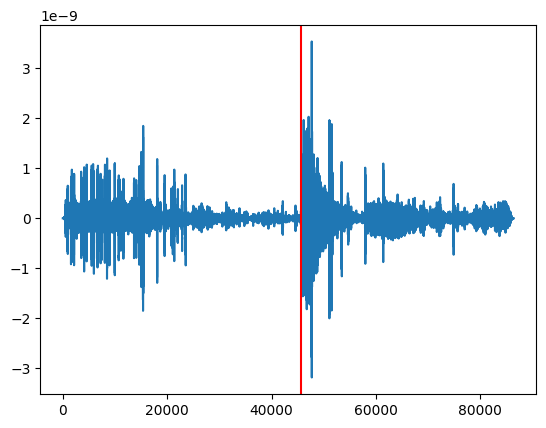

In [9]:
plot(
    time,
    v,
    target
)
plt.show()

## Analysing the waves through fourier analysis

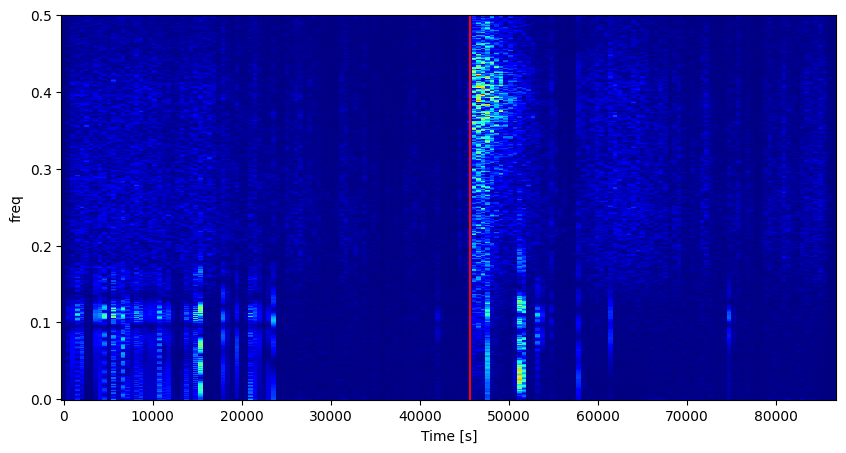

(513,)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from matplotlib import cm

def spectogram_fft(vel, sampling_rate, arrive) -> None:
    frequencies, times, Zxx = stft(vel, fs=sampling_rate, nperseg=1024)
    fig, ax = plt.subplots(figsize = (10, 5), dpi = 100, ncols = 1, nrows = 1)
    ax.set(ylabel = "freq", xlabel = "Time [s]")
    ax.axvline(arrive, color = 'red')
    ax.pcolormesh(times, frequencies, np.abs(Zxx), cmap = cm.jet)
    plt.show()
    print(frequencies.shape)

spectogram_fft(v, 1, target)

## Applying gaussian filters to the data

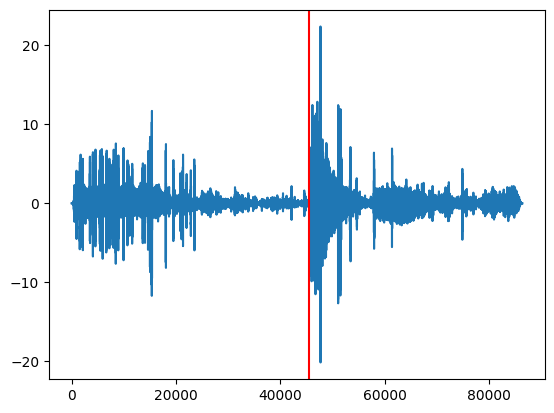

In [11]:
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
filtered: NDArray = gaussian_filter(v, v.std())
normed_filtered:NDArray = StandardScaler().fit_transform(filtered.reshape(-1, 1)).reshape(-1)
plot(
    time,
    normed_filtered,
    target
)

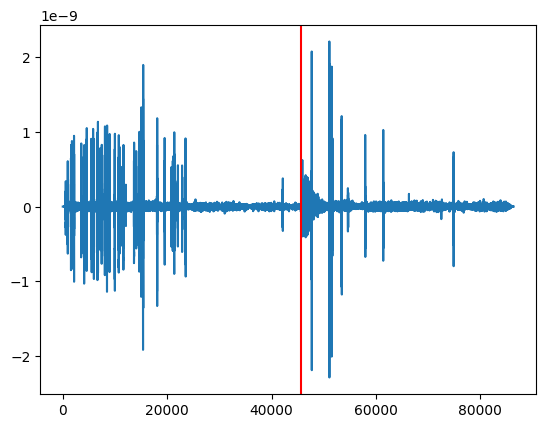

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a
    
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

out = bandpass_filter(v, 0.1, 10, fs = 60)

plot(
    time,
    gaussian_filter(out, out.std()),
    target
)

## Total variance analysis

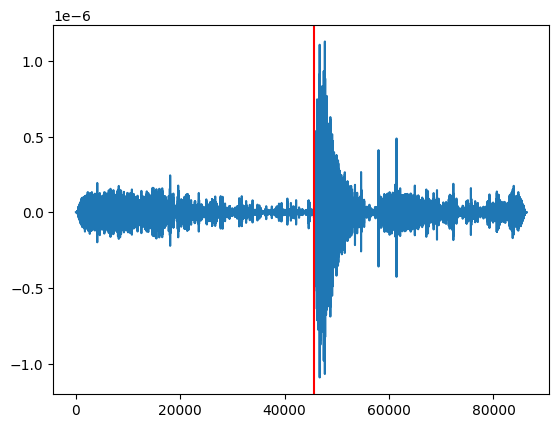

In [14]:
from utils import tv_analysis
chunk_size: int = 10
plot(
    time[:-chunk_size],
    tv_analysis(chunk_size, v).reshape(-1, 1),
    target
)
